In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [7]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

price2 = pd.read_csv("../data generators/generated_price_data/eth-usd_daily.csv")
price2 = price2[['market','day','close']]
price2.index = price2['day']
price2 = price2[(price2['day'] >= start_date) & (price2['day'] <= finish_date)]

g_trends = pd.read_csv("../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

g_trends2 = pd.read_csv("../data generators/generated_trends_data/ethereum_daily.csv")
g_trends2 = g_trends2[['keyword','day','trend']]
g_trends2.index = g_trends2['day']
g_trends2 = g_trends2[(g_trends2['day'] >= start_date) & (g_trends2['day'] <= finish_date)]

g_trends3 = pd.read_csv("../data generators/generated_trends_data/coinbase_daily.csv")
g_trends3 = g_trends3[['keyword','day','trend']]
g_trends3.index = g_trends3['day']
g_trends3 = g_trends3[(g_trends3['day'] >= start_date) & (g_trends3['day'] <= finish_date)]

w_pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

w_pageview2 = pd.read_csv("../data generators/generated_wiki_pageview_data/Ethereum_daily.csv")
w_pageview2 = w_pageview2[['article','day','pageview']]
w_pageview2.index = w_pageview2['day']
w_pageview2 = w_pageview2[(w_pageview2['day'] >= start_date) & (w_pageview2['day'] <= finish_date)]

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Feature Extraction
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.concatenate((features,d))
    return features[1:,:]

preds = dict()
window_len_list = [14,21,30,120,365]
for window_len in window_len_list:
    print('window_len',window_len)
    price_features = create_features(price,'close',window_len)
    price2_features = create_features(price2,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    g_trends3_features = create_features(g_trends3,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)
    w_pageview2_features = create_features(w_pageview2,'pageview',window_len)


    features = np.hstack((price_features,
                          price2_features,
                          g_trends_features,
                          g_trends2_features,
                          g_trends3_features,
                          w_pageview_features,
                          w_pageview2_features))
    
    features_small = np.hstack((price_features,price2_features))
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    
    returns2 = (price2['close'] / price2['close'].shift(1))-1
    returns2 = returns2[window_len:]
    
    classes1 = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes1 = classes1.reshape(classes1.shape[0],1)
    
    classes2 = np.array([ 1 if r >= 0 else -1 for r in returns2 ])
    classes2 = classes2.reshape(classes2.shape[0],1)
    
    classes = np.hstack((classes1, classes2))

    ### Model Training & Hyperparameter Tuning

    features_dict = {'all':features,'price':features_small}
    #features_dict = {'all':features}
    for features_k in features_dict.keys():
        print('features',features_k)
        features = features_dict[features_k]
        train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
        x_train = features[:train_len,:]
        y_train = classes[:train_len,:]

        x_test = features[train_len:,:]
        y_test = classes[train_len:,:]

        random_grid = {'n_estimators': [10,25,50,100],
                       'max_features': ['auto','sqrt'],
                       'max_depth': [5,10,25,50], 
                       'min_samples_split': [5,10,20],
                       'min_samples_leaf': [1,5,10],
                       'bootstrap': [True,False]}

        rf = RandomForestClassifier()
        rf_random = RandomizedSearchCV(estimator = rf, 
                                       param_distributions = random_grid, 
                                       n_iter = 50, 
                                       cv = 5, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
        #Fit the random search model
        rf_random.fit(x_train, y_train)

        model = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'],
                                       min_samples_split=rf_random.best_params_['min_samples_split'],
                                       min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
                                       max_features=rf_random.best_params_['max_features'],
                                       max_depth=rf_random.best_params_['max_depth'],
                                       bootstrap=rf_random.best_params_['bootstrap'])
        model.fit(x_train,y_train)

        print('\ttraining score:',model.score(x_train, y_train))
        print('\ttest score:',model.score(x_test,y_test))
        
        preds['rf_w'+str(window_len)+'_feature_'+features_k] = model.predict(x_test)[1:]

window_len 14
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   19.3s finished


	training score: 0.9737206085753803
	test score: 0.3629976580796253
features price
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   13.7s finished


	training score: 0.7863070539419087
	test score: 0.3442622950819672
window_len 21
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   26.0s finished


	training score: 0.9722029186935371
	test score: 0.34192037470725994
features price
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   15.9s finished


	training score: 0.9221681723419041
	test score: 0.34192037470725994
window_len 30
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   30.1s finished


	training score: 0.9279720279720279
	test score: 0.3629976580796253
features price
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.5s finished


	training score: 0.9552447552447553
	test score: 0.3372365339578454
window_len 120
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   52.0s finished


	training score: 0.823134328358209
	test score: 0.32786885245901637
features price
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   29.3s finished


	training score: 0.5156716417910447
	test score: 0.3325526932084309
window_len 365
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.2min finished


	training score: 0.94337899543379
	test score: 0.3255269320843091
features price
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   45.4s finished


	training score: 0.8849315068493151
	test score: 0.28337236533957844


In [19]:
preds.keys()

dict_keys(['rf_w14_feature_all', 'rf_w14_feature_price', 'rf_w21_feature_all', 'rf_w21_feature_price', 'rf_w30_feature_all', 'rf_w30_feature_price', 'rf_w120_feature_all', 'rf_w120_feature_price', 'rf_w365_feature_all', 'rf_w365_feature_price'])

In [22]:
preds['rf_w14_feature_all'][:,1]

array([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,
        1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1,
       -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1,
        1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,
        1,  1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1,
        1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,
        1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1, -1,  1

## Momentum with Random Forest 

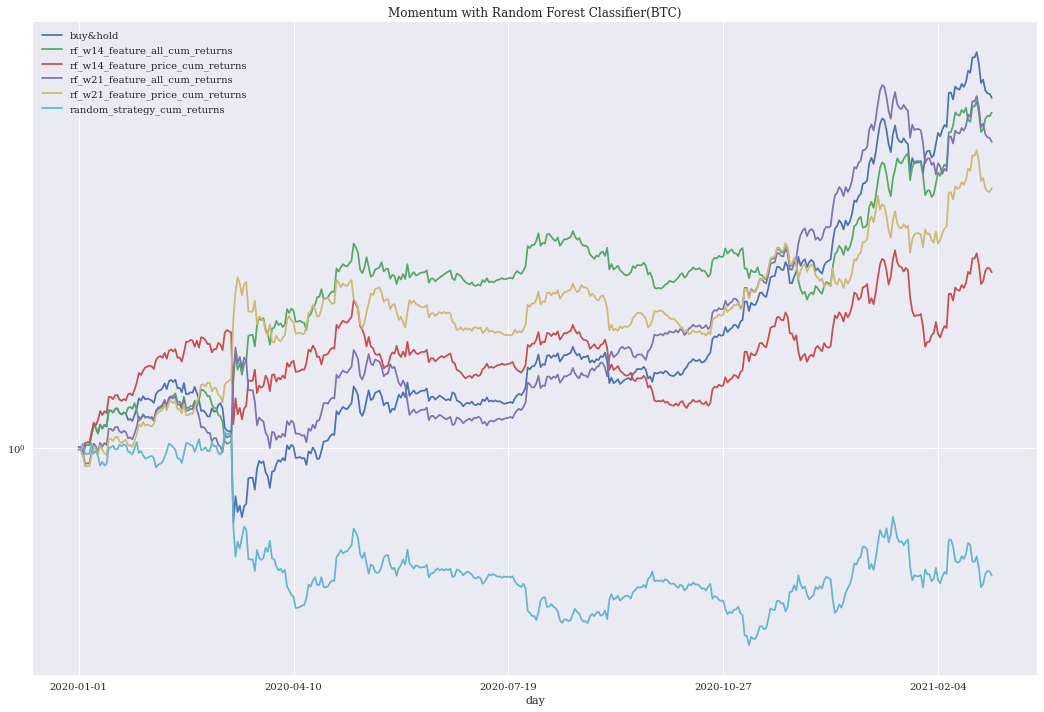

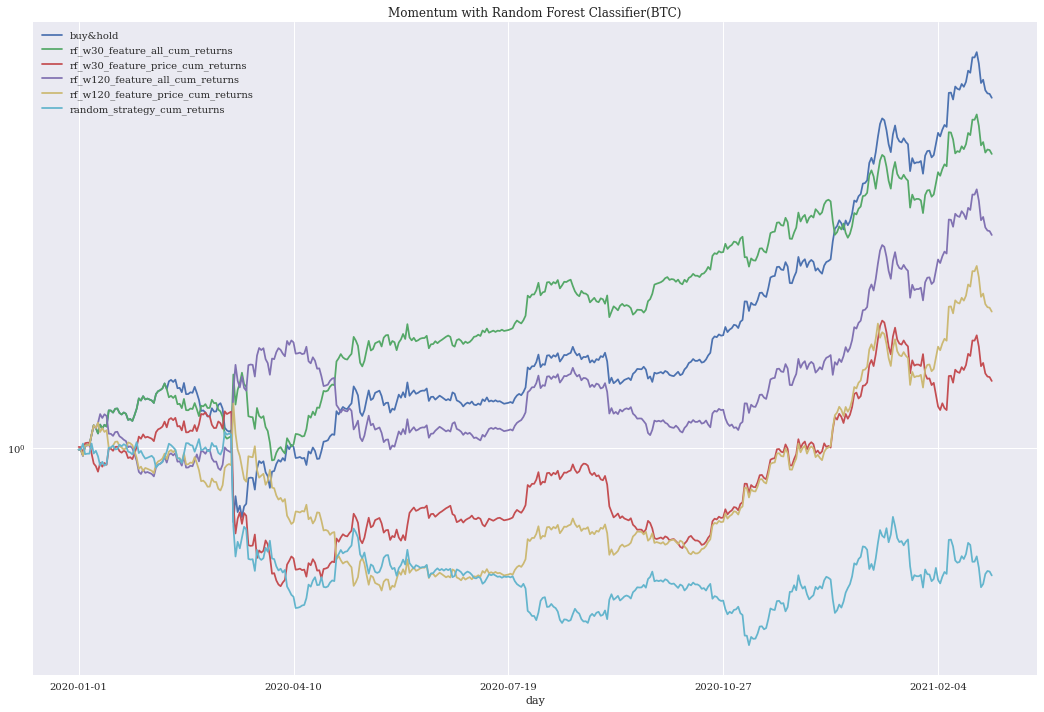

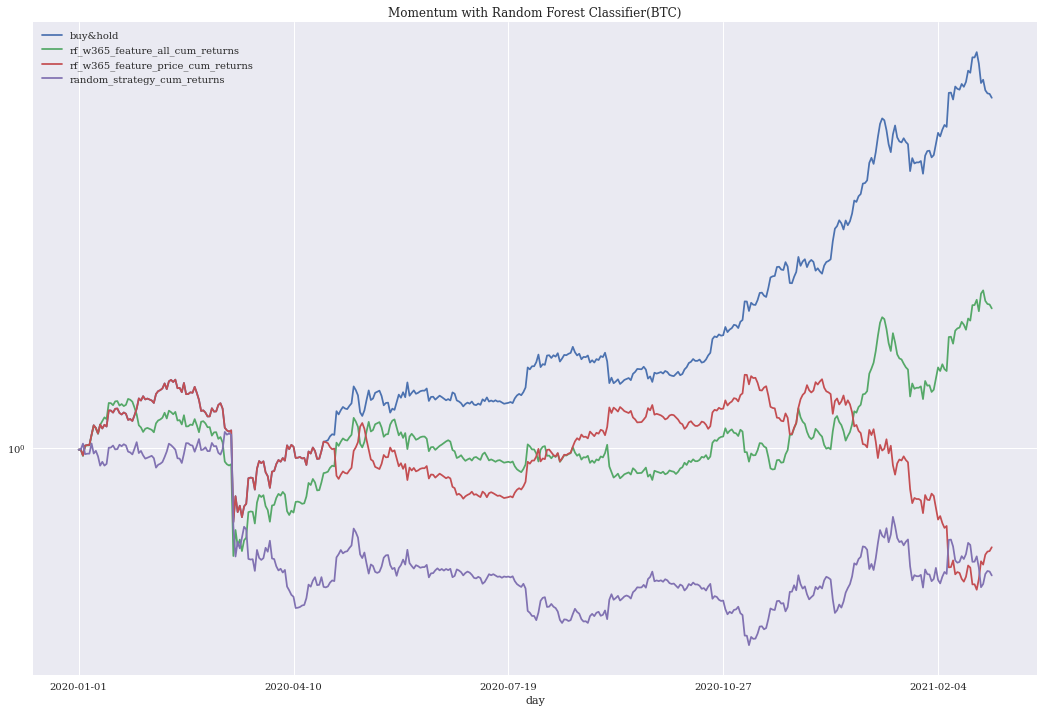

In [29]:
#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()


#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp][:,0] * test_data['returns']
test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()
    
plot_title = "Momentum with Random Forest Classifier(BTC)"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:4]+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_columns2 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][4:-2]+['random_strategy_cum_returns']
ax = returns_data[plot_columns2].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_columns3 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][-2:]+['random_strategy_cum_returns']
ax = returns_data[plot_columns3].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

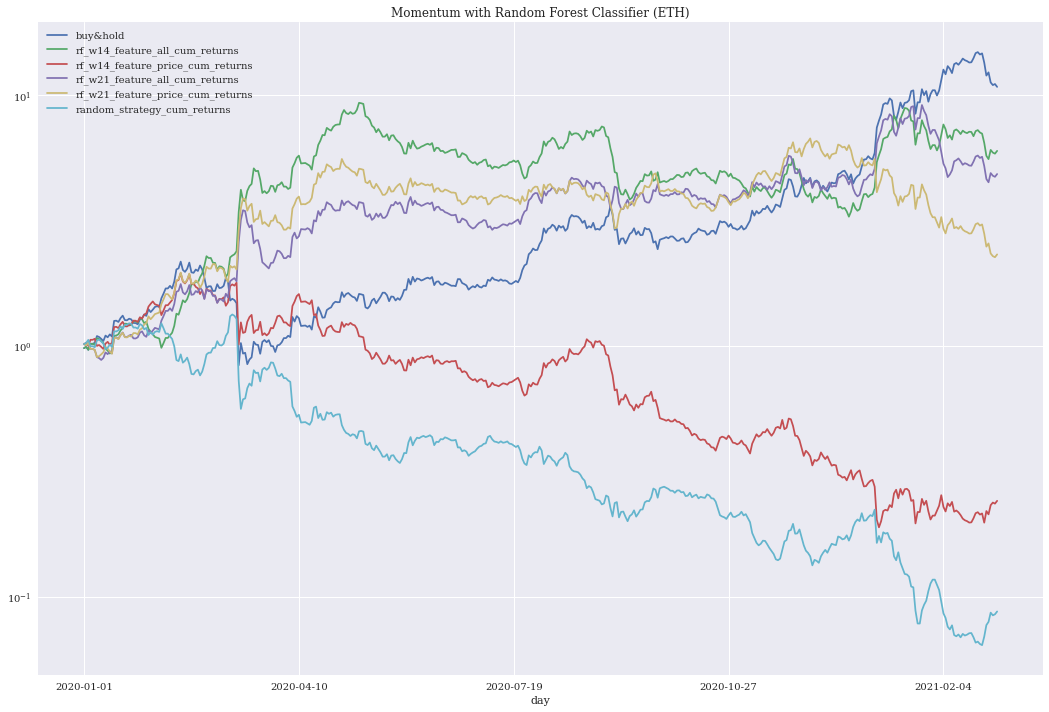

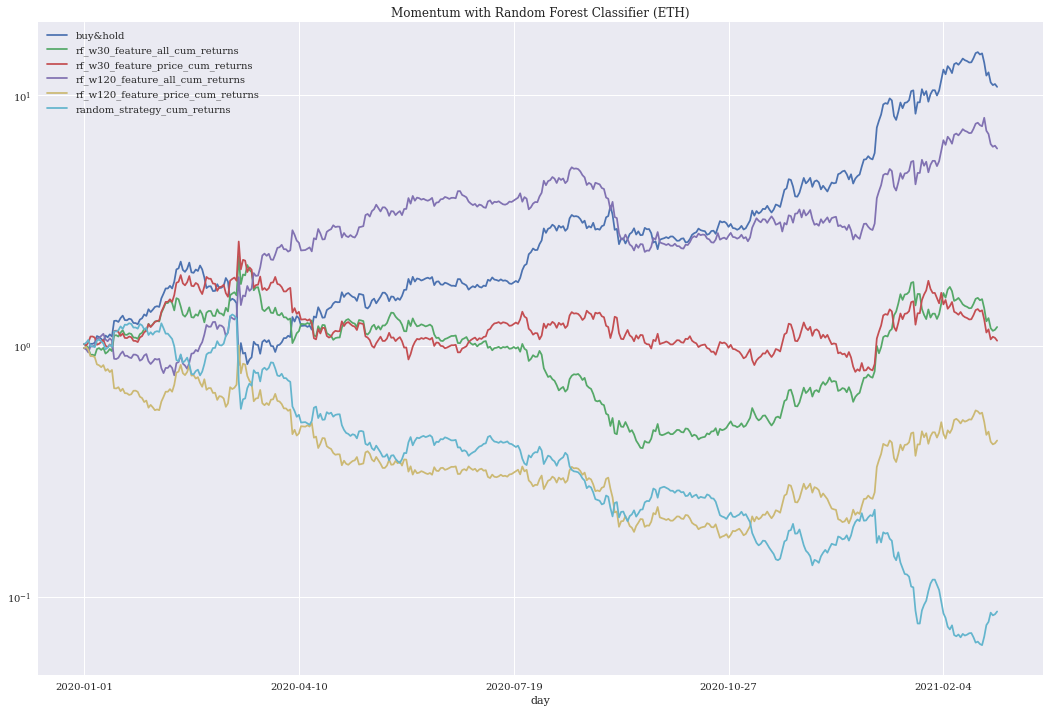

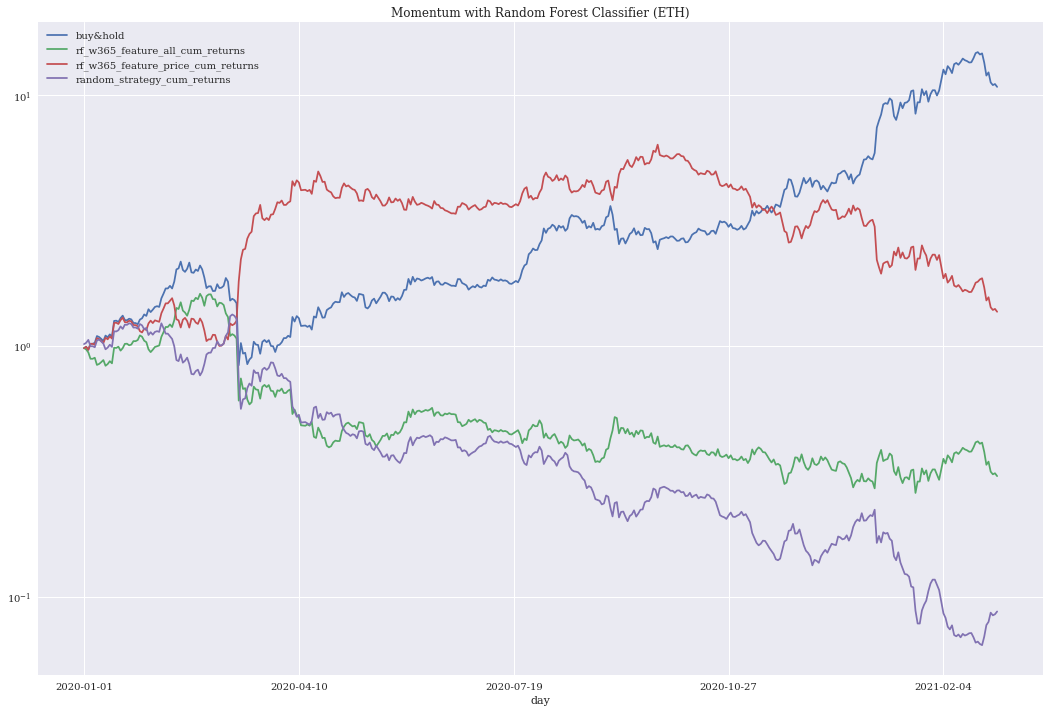

In [30]:
#take proportion of the data
test_data = price2[(price2['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()

#find returns
test_data = price2[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp][:,1] * test_data['returns']
test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()
    
plot_title = "Momentum with Random Forest Classifier (ETH)"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:4]+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_columns2 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][4:-2]+['random_strategy_cum_returns']
ax = returns_data[plot_columns2].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_columns3 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][-2:]+['random_strategy_cum_returns']
ax = returns_data[plot_columns3].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

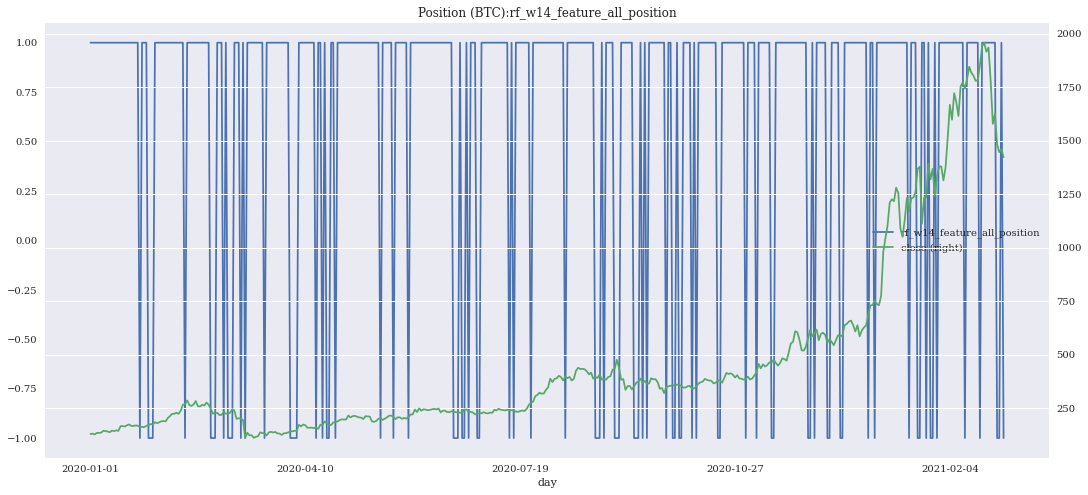

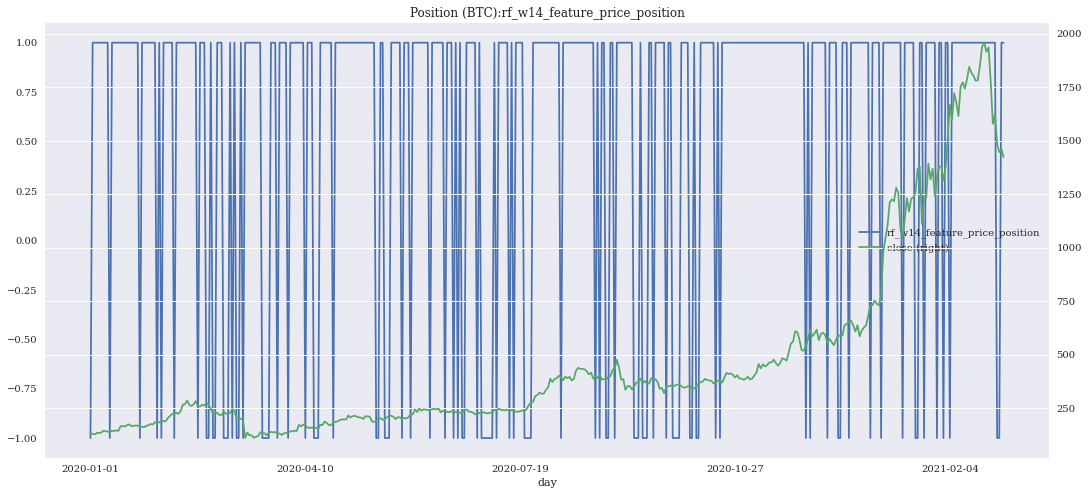

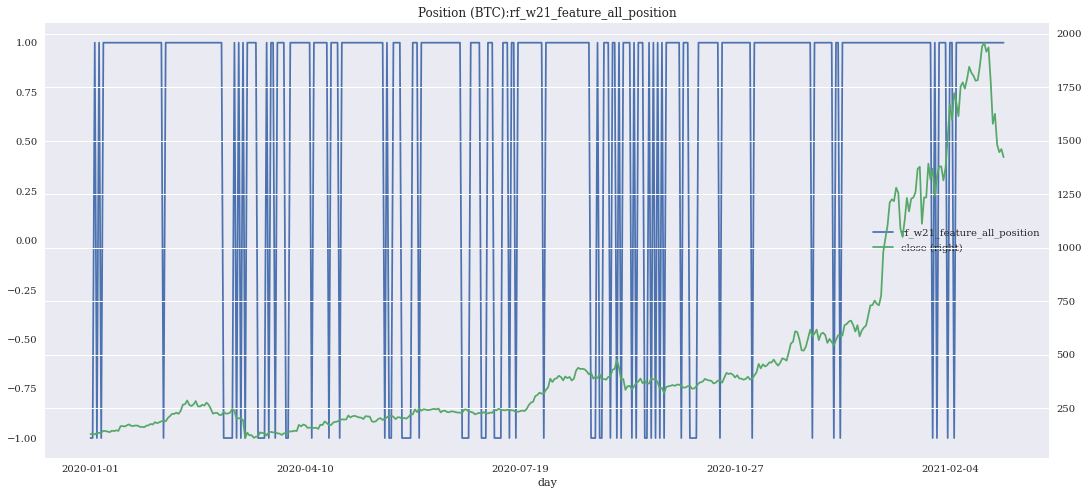

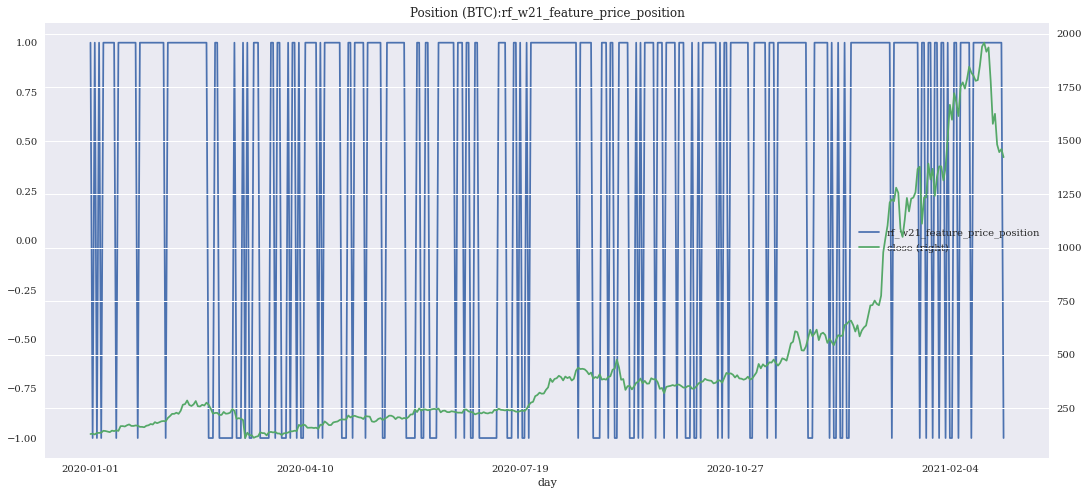

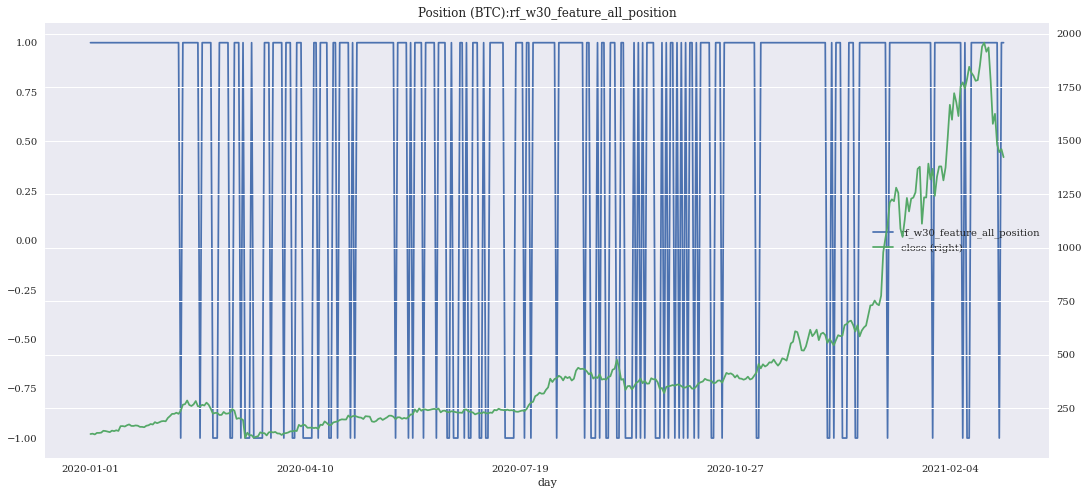

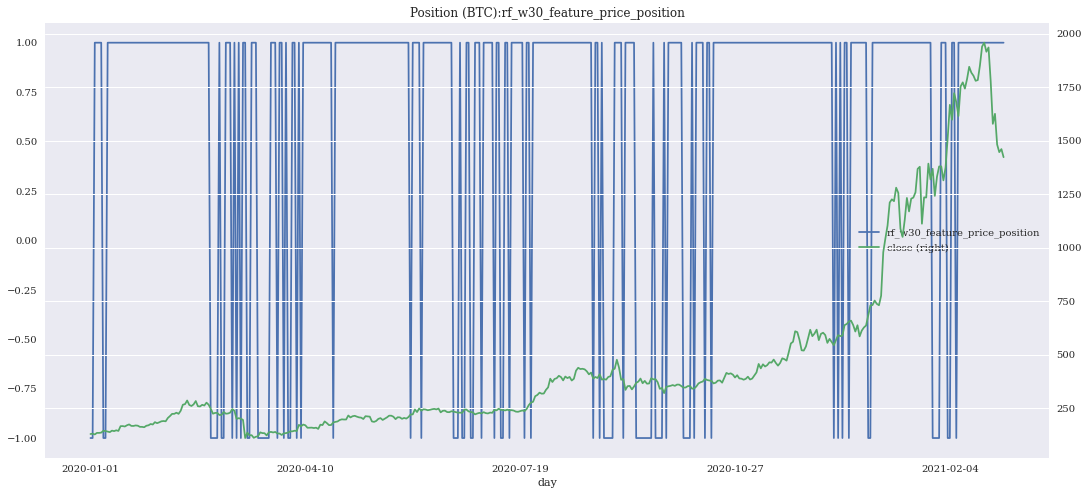

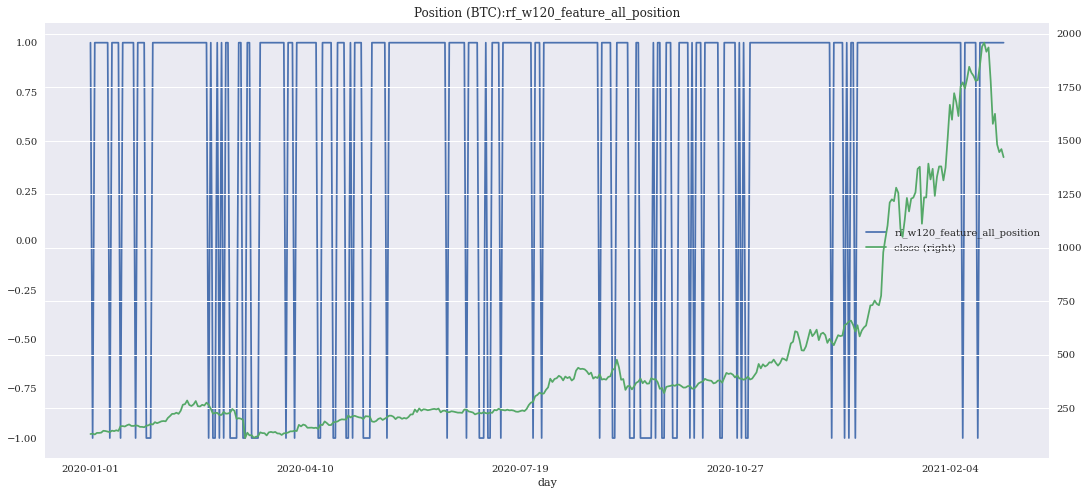

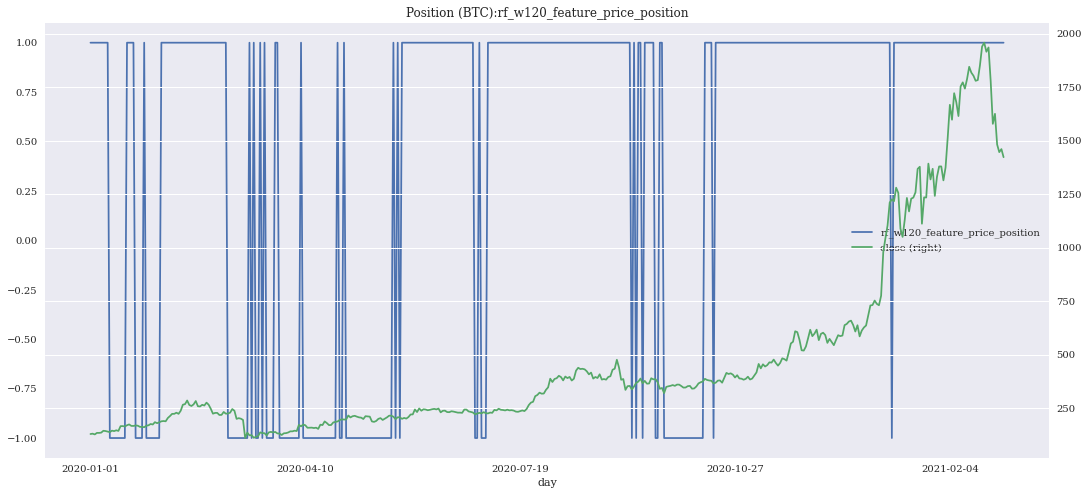

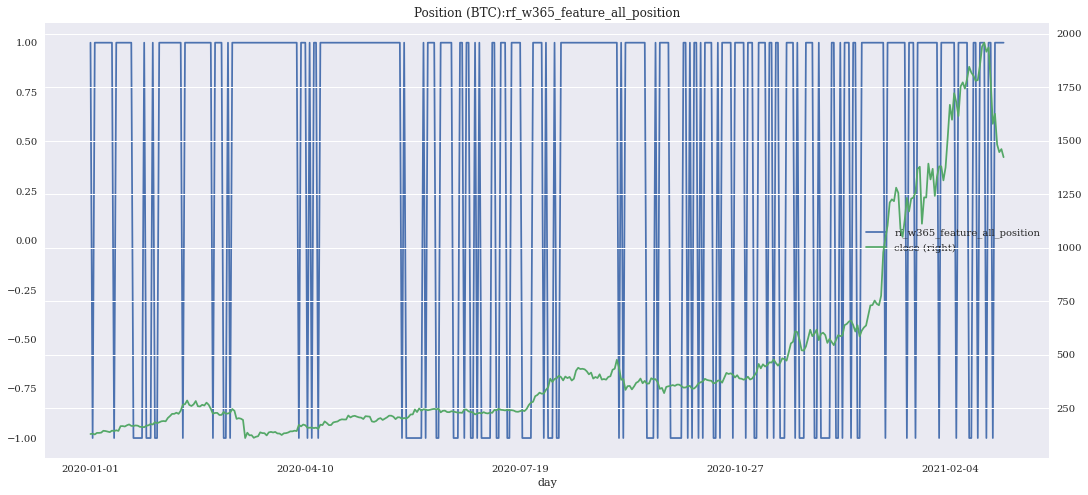

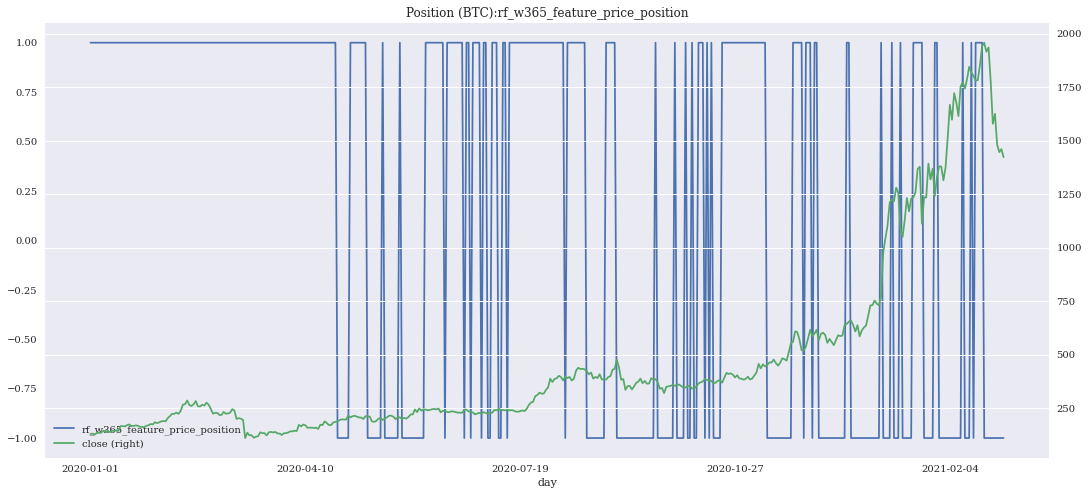

In [27]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp][:,0]
    ax = test_data[[kp+'_position','close']].plot(title='Position (BTC):'+kp+'_position',secondary_y='close',figsize=(18, 8))

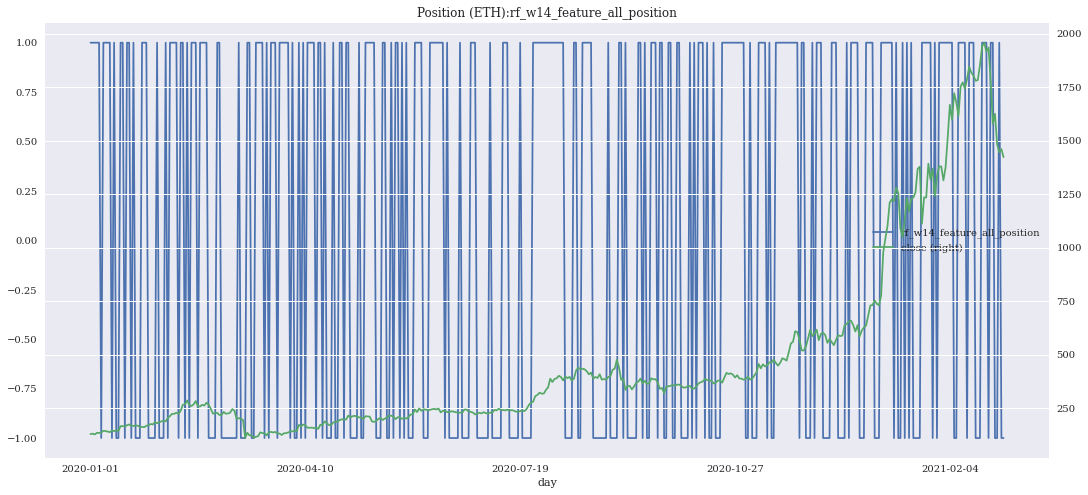

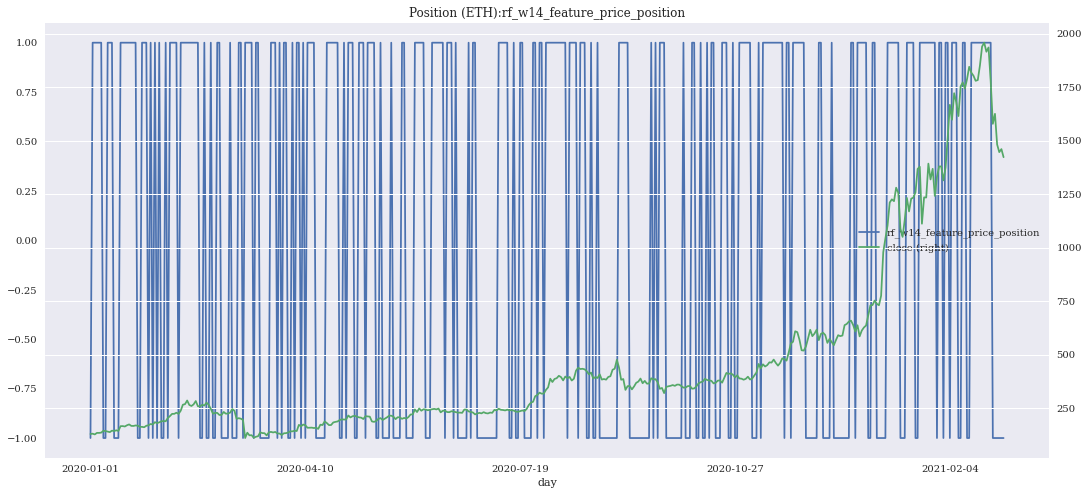

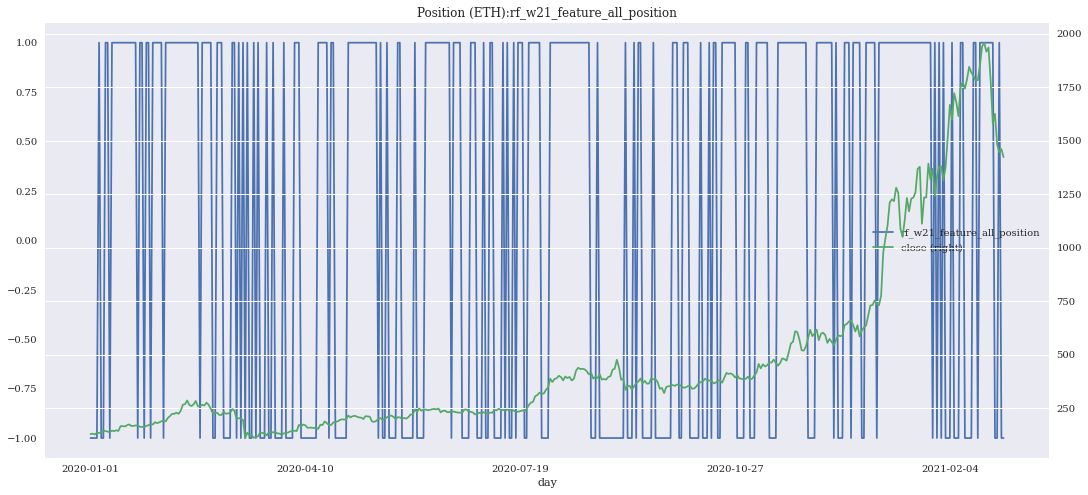

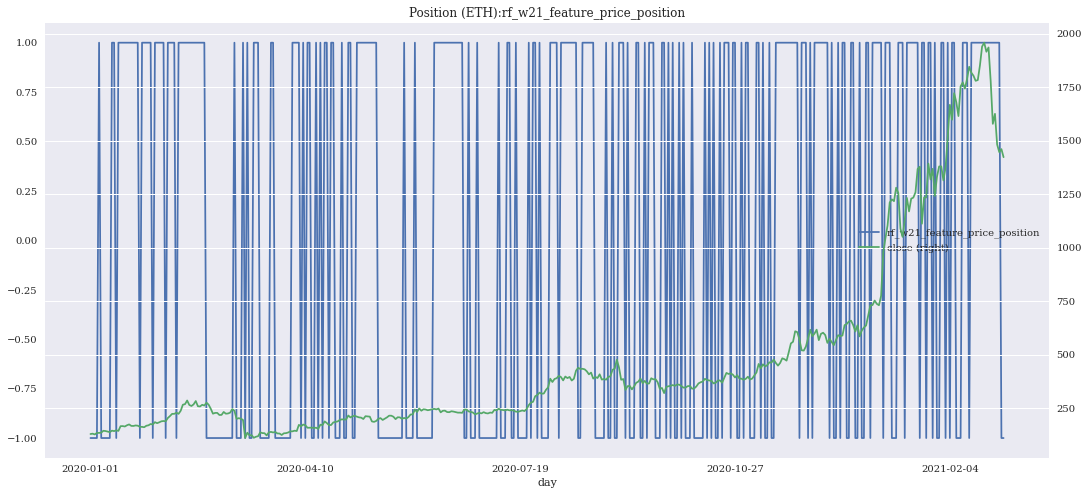

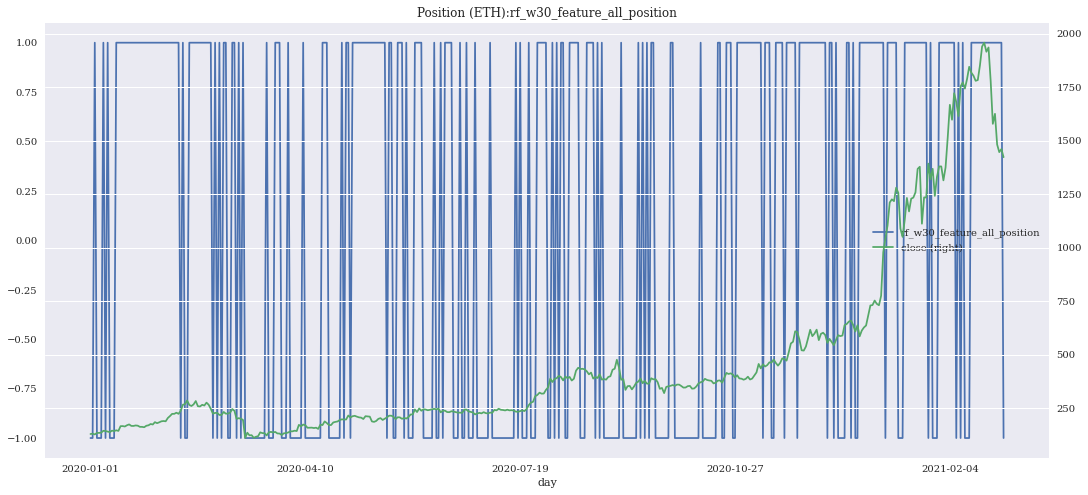

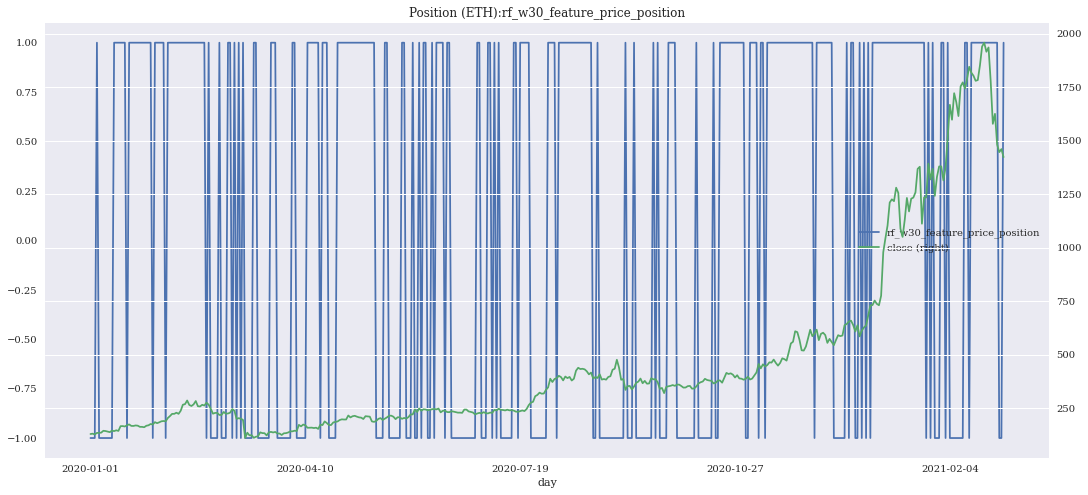

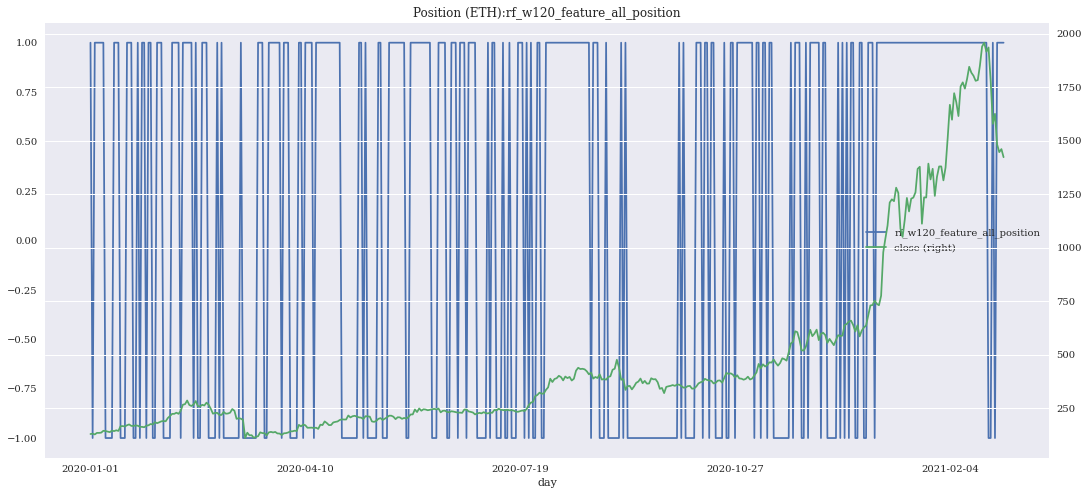

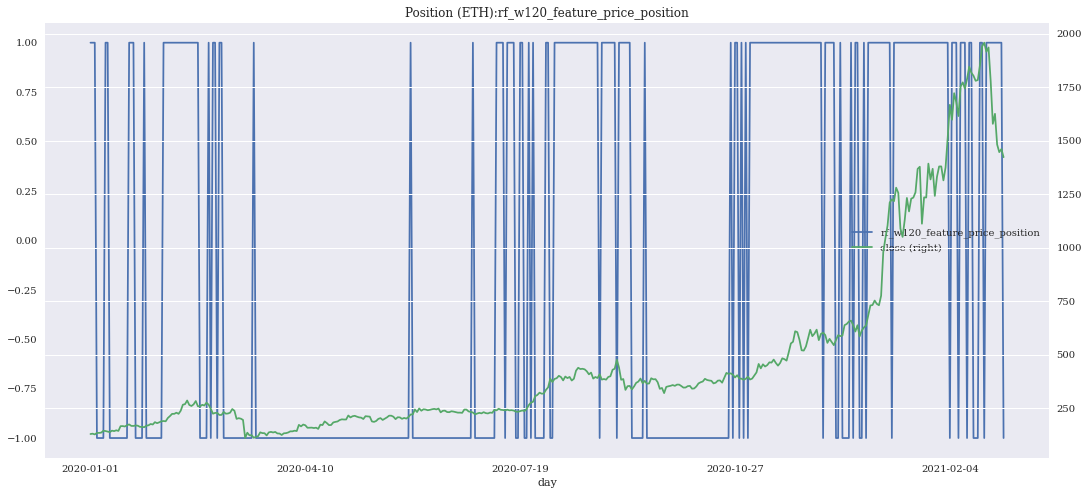

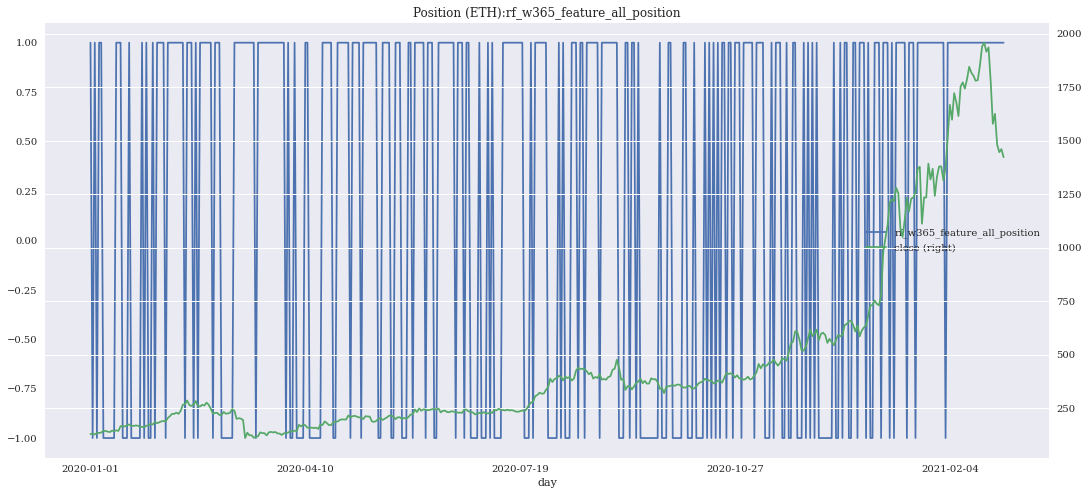

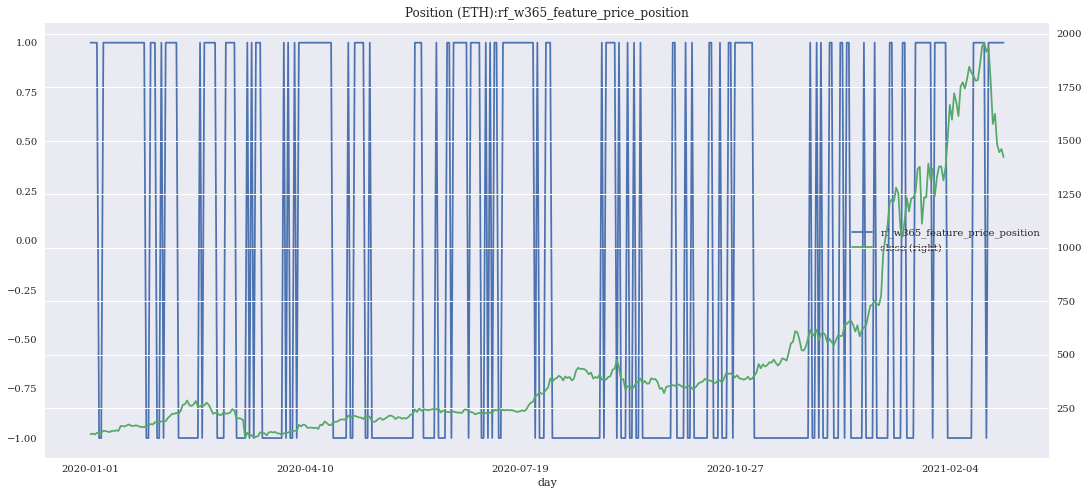

In [28]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp][:,1]
    ax = test_data[[kp+'_position','close']].plot(title='Position (ETH):'+kp+'_position',secondary_y='close',figsize=(18, 8))